In [89]:
!pip install -q fastbook

import fastbook
fastbook.setup_book()

In [ ]:
from fastai.vision.all import *

# 1. Data loading and augmentation

Create a DataBlock and DataLoaders using:
- Training and validation images collected in Lab2
- `Resize(640)` as item transform
- A size of 420 in the batch transforms
- Use a batch size of 32
- Use `set_seed()` to obtain reproducible results.
- Augmentations you find useful (see question 1)

Show a training and a validation batch.
Show augmentations, i.e. `show_batch()` with `unique=True`.

In [114]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter('train','valid'), 
    get_y=parent_label, 
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420, do_flip=True))

In [115]:
set_seed(42,True)
dls = images.dataloaders("/content/gdrive/MyDrive/Colab Notebooks/", batch_size=32, seed=42)

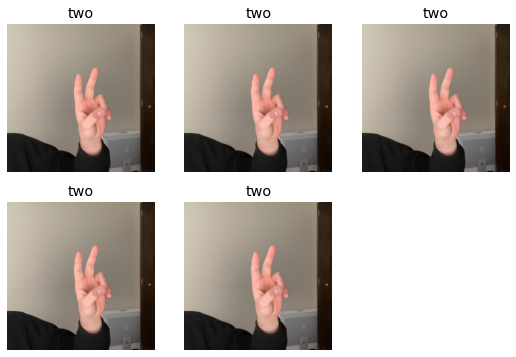

In [119]:
dls.valid.show_batch(max_n=5, unique=True)

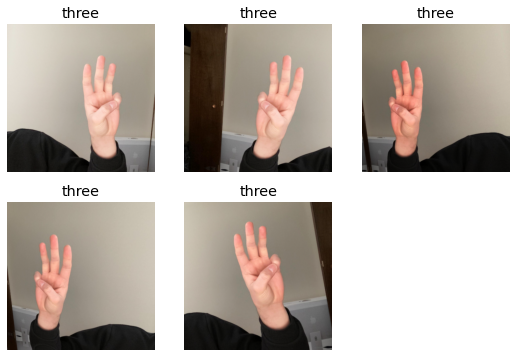

In [120]:
dls.train.show_batch(max_n=5, unique=True)

### Question 1: How did you choose your augmentation transfroms? Include your thought process.

I just did flipped the image, I simply used do_flip. Some augmentations, I believe, should be used with caution. As a result, I chose one that will most likely have no or little affect on the model's prediction. If I used crop, for example, it might crop out a finger out of the picture or maybe the hand in which the model will focus in the background.

### Question 2: Are there any problems with your augmentations in the training data, or validation data, e.g. fingers missing, etc.?

No, my augmentations aren't causing any issues because I didn't use any augmentation that would cover or make a finger disappear in the image.


# 2. Train the classifier

## 2.1 Train a fastai cnn multi-class classifier
- ResNet18 architecture.
- accuracy as metric.
- learning rate finder to find initial learning rate.
- transfer learning with unfreezing using descriminative learning rates.
- use a batch size of 32 and the DataBlock from above.
- Use the same `set_seed()` as above to obtain reproducible results.

SuggestedLRs(valley=0.002511886414140463)

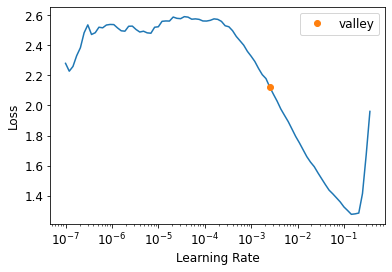

In [92]:
set_seed(42,True)
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(valid_name='valid'), 
    get_y=parent_label, 
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420, do_flip=True))
dls = images.dataloaders("/content/gdrive/MyDrive/Colab Notebooks/", batch_size=32, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.lr_find()

In [94]:
set_seed(42,True)
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(valid_name='valid'), 
    get_y=parent_label, 
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420, do_flip=True))
dls = images.dataloaders("/content/gdrive/MyDrive/Colab Notebooks/", batch_size=32, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3, base_lr= 5e-3)



epoch,train_loss,valid_loss,accuracy,time
0,1.716376,3.208850,0.340000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.488718,1.483324,0.600000,00:12
1,0.293546,0.169743,0.940000,00:11
2,0.263168,0.097298,0.980000,00:11


In [95]:
learn.unfreeze()

SuggestedLRs(valley=4.365158383734524e-05)

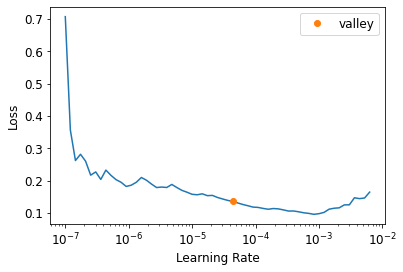

In [97]:
learn.lr_find()

In [101]:
learn.fit_one_cycle(1, lr_max= 6e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.027507,0.055688,1.000000,00:11


### Question 3: How did you select the number of epochs and learning rates? 
- Depending on accuracy, I chose the number of epochs. I stopped just as my accuracy began to worsen.
- learning rate I chose between steepest point and valley. Abit closer to steepest point.
- After unfreeze, for the learning rate, I chose the area where there was a low loss and a down slope.




## 2.2 Experiment with different batch sizes
Using the pipeline, number of epochs, learning rates from above, re-run the pipeline with a batch size of 16, 64

In [104]:
set_seed(42,True)
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(valid_name='valid'), 
    get_y=parent_label, 
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420, do_flip=True))
dls = images.dataloaders("/content/gdrive/MyDrive/Colab Notebooks/", batch_size=16, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3, base_lr= 5e-3)
learn.unfreeze()
learn.fit_one_cycle(1, lr_max= 6e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.595264,2.029471,0.280000,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.340903,1.492681,0.680000,00:11
1,0.292861,0.594882,0.820000,00:10
2,0.222491,0.285176,0.920000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.070243,0.484488,0.840000,00:10


In [113]:
set_seed(42,True)
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(valid_name='valid'), 
    get_y=parent_label, 
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420, do_flip=True))
dls = images.dataloaders("/content/gdrive/MyDrive/Colab Notebooks/", batch_size=64, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3, base_lr= 5e-3)
learn.unfreeze()
learn.fit_one_cycle(1, lr_max= 6e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.119230,3.719034,0.360000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.878189,2.796363,0.500000,00:12
1,0.542515,1.684381,0.580000,00:12
2,0.405093,0.658543,0.720000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.082553,0.171438,0.960000,00:12


### Question 4: Keeping number of epochs and learning rates the same, how are validation loss and accuracy effected by the increase and decrease of batch size? 

- the larger the batch size the more accurate and stable estimate of dataset but it will take longer to process per epochs.
- the smaller the batch the less accurate the model should be.
- the train loss will alway get better with a larger batch size.
- after descriminative learning rates, the larger the batch size the better the accuracy.
- before descriminative learning rates, the smaller batch size the better accuracy but this may be because just because the learning rate just happens to be lower in the steep part. 



# 3. Analyze model performance
Retrain the model with batch size of 32 from the previous section.

Plot the confusion matrix.

In [109]:
set_seed(42,True)
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(valid_name='valid'), 
    get_y=parent_label, 
    item_tfms=Resize(640),
    batch_tfms=aug_transforms(size=420, do_flip=True))
dls = images.dataloaders("/content/gdrive/MyDrive/Colab Notebooks/", batch_size=32, seed=42)
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(3, base_lr= 5e-3)
learn.unfreeze()
learn.fit_one_cycle(1, lr_max= 6e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.716376,3.208850,0.340000,00:15


epoch,train_loss,valid_loss,accuracy,time
0,0.488718,1.483324,0.600000,00:11
1,0.293546,0.169743,0.940000,00:11
2,0.263168,0.097298,0.980000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.115816,0.102340,0.960000,00:11


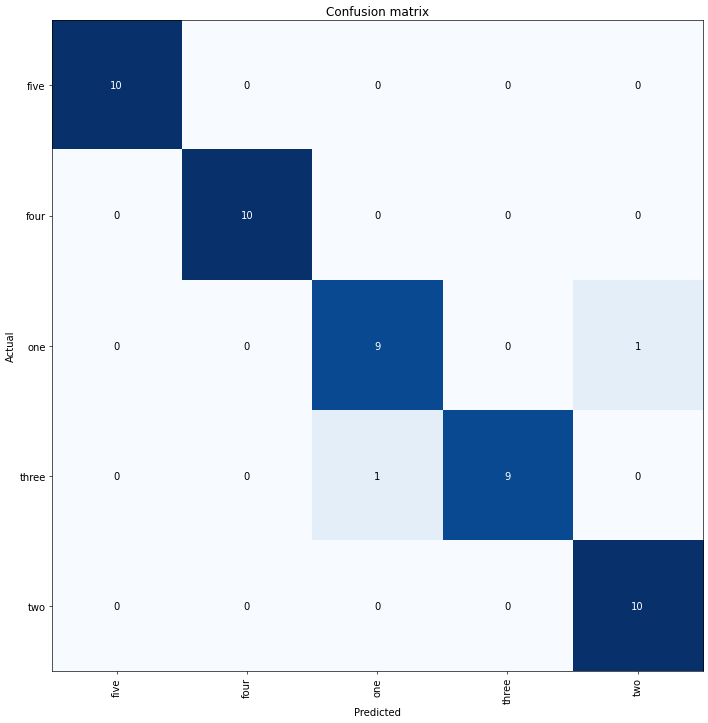

In [110]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# 4. Save the best model to file
Save the model using `learn.export()` as `.pkl` file. Verify that the model can be reloaded and used to make predictions.

In [111]:
learn.export(fname=("/content/gdrive/MyDrive/Colab Notebooks/imageclassifier2.pkl"))

In [112]:
learn = load_learner('/content/gdrive/MyDrive/Colab Notebooks/imageclassifier2.pkl')

In [ ]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
btn_upload #image taken just now. hidden test data.

FileUpload(value={}, description='Upload')

In [ ]:
img = PILImage.create(btn_upload.data[-1])

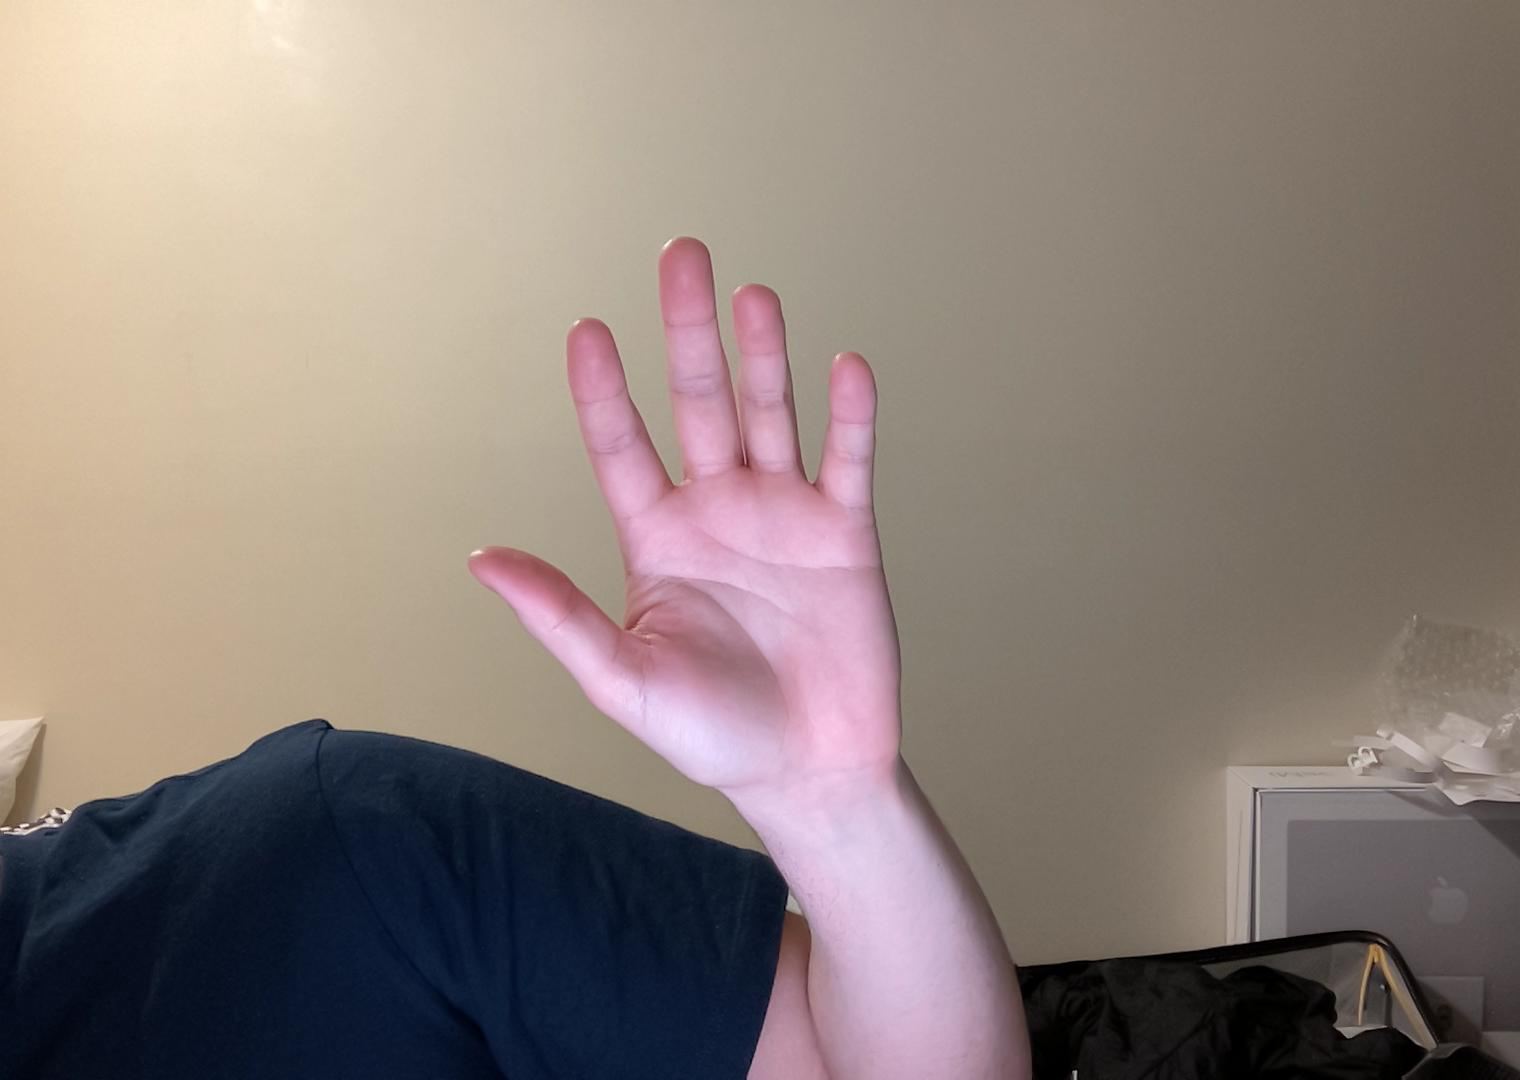

In [ ]:
img

In [ ]:
learn.predict(img)

('five',
 TensorBase(0),
 TensorBase([9.9759e-01, 3.6849e-04, 1.0269e-04, 2.3934e-04, 1.7019e-03]))

# 5. Summary and Conclusion

Summarize:
- Augmentations used
- Training strategy, including batch size, number of epochs and learning rates.
- Accuracy achieved, summary of confusion matrix

- I only used one augmentation: flipping the image. I didn't want to use anything else because there aren't many images to train with and it would most likely affect the model.
- training strategy: after learning rate finder, I found a spot between valley and the steep points of the graph. Didnt want to use the min point as it may cause divergence. Then, unfreeze and found learning rate again. For learning rate this time, I chose a down sloping part of the graph. 
- I achieved an accuracy of 96.
- Confusion matrix looks good only 2 false answers the rest were correct. 


Conclusion:
- Are you satisfied with model performance? Why, why not?

I am staisfied with my model since 96 accuracy is pretty good specially considering the small amount of training images.Also, confusion matrix displays what the model can do and it seems pretty good. Lastly, I tested on five different images that I just took to check how the model would do. The model predicted correctly on all five images.


# 6.Reflection
Include a sentence or two about
- what you liked or disliked,
- found interesting, confusing, challangeing, motivating

while working on this assignment.

- I liked how we got to make are own model and see if it can perform well with new dataset. 
- I disliked how it takes forever to compile when training the classifier.
- I found intresting the process. learned some stuff I was unsure of as I was going through the lab. 

